In [1]:
!pip install prophet

In [2]:
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime
from prophet import Prophet


from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")
color_pal = sns.color_palette()
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

C:\Users\akash\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# DATA

In [3]:
df=pd.read_csv("APPLE BP DATA.csv")

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,NASDAQ,Change
0,01-04-2014,19.205713,19.352501,19.170357,19.344643,200760000,3658.399902,NaN
1,02-04-2014,19.370714,19.410000,19.295000,19.376785,180420800,3665.989990,0.032142
2,03-04-2014,19.335358,19.375000,19.201429,19.242500,162344000,3637.580078,-0.134285
3,04-04-2014,19.278929,19.285713,18.949286,18.993570,275251200,3539.379883,-0.248930
4,07-04-2014,18.857857,18.960714,18.638929,18.695356,289850400,3507.750000,-0.298214


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2205 non-null   object 
 1   Open    2205 non-null   float64
 2   High    2205 non-null   float64
 3   Low     2205 non-null   float64
 4   Close   2205 non-null   float64
 5   Volume  2205 non-null   int64  
 6   NASDAQ  2205 non-null   float64
 7   Change  2204 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 137.9+ KB


## Convert the "time" column to the datetime type

In [6]:
df["Date"] = pd.to_datetime(df["Date"])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2205 non-null   datetime64[ns]
 1   Open    2205 non-null   float64       
 2   High    2205 non-null   float64       
 3   Low     2205 non-null   float64       
 4   Close   2205 non-null   float64       
 5   Volume  2205 non-null   int64         
 6   NASDAQ  2205 non-null   float64       
 7   Change  2204 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 137.9 KB


In [8]:
df.set_index('Date',inplace=True)

In [9]:
df.head()

,Open,High,Low,Close,Volume,NASDAQ,Change
Date,,,,,,,
2014-01-04,19.205713,19.352501,19.170357,19.344643,200760000,3658.399902,NaN
2014-02-04,19.370714,19.410000,19.295000,19.376785,180420800,3665.989990,0.032142
2014-03-04,19.335358,19.375000,19.201429,19.242500,162344000,3637.580078,-0.134285
2014-04-04,19.278929,19.285713,18.949286,18.993570,275251200,3539.379883,-0.248930
2014-07-04,18.857857,18.960714,18.638929,18.695356,289850400,3507.750000,-0.298214


In [10]:
df.tail()

,Open,High,Low,Close,Volume,NASDAQ,Change
Date,,,,,,,
2022-12-23,130.919998,132.419998,129.639999,131.860001,63814900,10985.45020,-0.369995
2022-12-27,131.380005,131.410004,128.720001,130.029999,69007800,10822.50977,-1.830002
2022-12-28,129.669998,131.029999,125.870003,126.040001,85438400,10679.33984,-3.989998
2022-12-29,127.989998,130.479996,127.730003,129.610001,75703700,10951.04981,3.570000
2022-12-30,128.410004,129.949997,127.430000,129.929993,77034200,10939.75977,0.319992


# Missing entries


In [11]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [12]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [13]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [14]:
all_datetimes.shape

(3283,)

# Supplying missing values


## Insert missing datetimes

In [15]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [16]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2205 non-null   float64
 1   High    2205 non-null   float64
 2   Low     2205 non-null   float64
 3   Close   2205 non-null   float64
 4   Volume  2205 non-null   float64
 5   NASDAQ  2205 non-null   float64
 6   Change  2204 non-null   float64
dtypes: float64(7)
memory usage: 334.2 KB


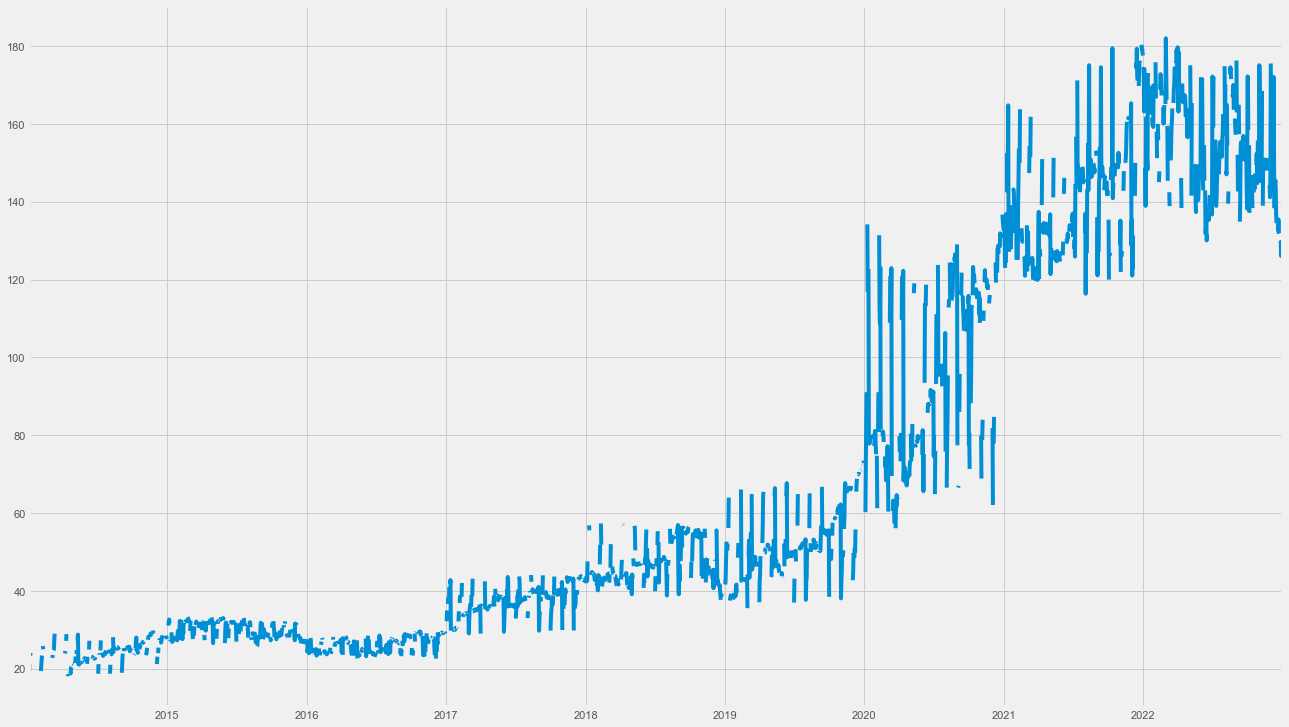

In [17]:
plot = df['Close'].plot(figsize=(20, 12))

# forward fill

In [18]:
df["ffilled"] = df["Close"].ffill()
df["NASDAQ"]=df["NASDAQ"].ffill()
df.head(12)

,Open,High,Low,Close,Volume,NASDAQ,Change,ffilled
2014-01-04,19.205713,19.352501,19.170357,19.344643,200760000.0,3658.399902,NaN,19.344643
2014-01-05,21.142857,21.242857,20.941429,21.124287,244048000.0,3594.360107,0.049645,21.124287
2014-01-06,NaN,NaN,NaN,NaN,NaN,3594.360107,NaN,21.124287
2014-01-07,23.379999,23.517500,23.282499,23.379999,152892000.0,3894.330078,0.147499,23.379999
2014-01-08,23.725000,24.155001,23.702499,24.032499,194044000.0,3879.669922,0.132499,24.032499
2014-01-09,NaN,NaN,NaN,NaN,NaN,3879.669922,NaN,24.032499
2014-01-10,25.147499,25.172501,24.674999,24.795000,205965200.0,3984.739990,-0.392500,24.795000
2014-01-11,NaN,NaN,NaN,NaN,NaN,3984.739990,NaN,24.795000
2014-01-12,29.702499,29.812500,27.817499,28.767500,335256000.0,4287.810059,-0.965000,28.767500
2014-01-13,NaN,NaN,NaN,NaN,NaN,4287.810059,NaN,28.767500


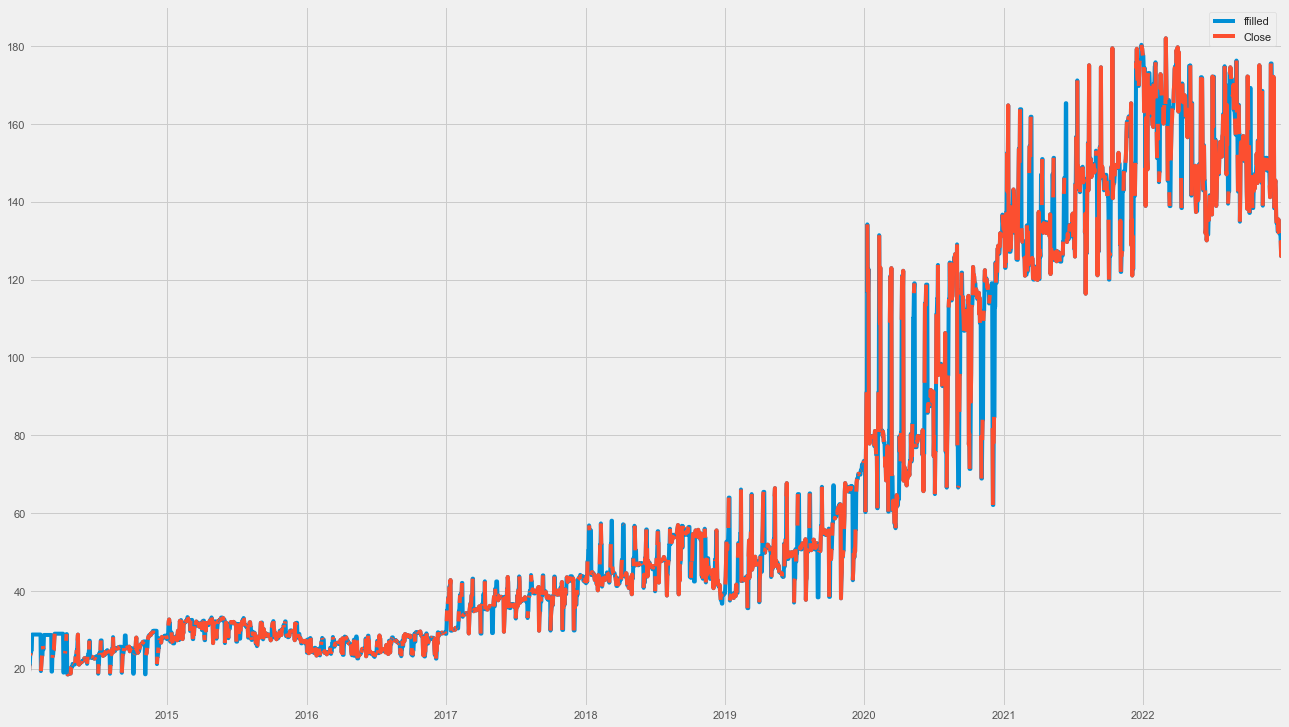

In [19]:
df = df[["ffilled", "Close","NASDAQ","Change"]]
plot = df[["ffilled", "Close"]].plot(figsize=(20, 12))

In [20]:
df.ffilled

2014-01-04     19.344643
2014-01-05     21.124287
2014-01-06     21.124287
2014-01-07     23.379999
2014-01-08     24.032499
                 ...    
2022-12-26    131.860001
2022-12-27    130.029999
2022-12-28    126.040001
2022-12-29    129.610001
2022-12-30    129.929993
Freq: D, Name: ffilled, Length: 3283, dtype: float64

In [21]:
df.rename(columns={"ffilled": "close"}, inplace=True)
df

,close,Close,NASDAQ,Change
2014-01-04,19.344643,19.344643,3658.399902,NaN
2014-01-05,21.124287,21.124287,3594.360107,0.049645
2014-01-06,21.124287,NaN,3594.360107,NaN
2014-01-07,23.379999,23.379999,3894.330078,0.147499
2014-01-08,24.032499,24.032499,3879.669922,0.132499
...,...,...,...,...
2022-12-26,131.860001,NaN,10985.450200,NaN
2022-12-27,130.029999,130.029999,10822.509770,-1.830002
2022-12-28,126.040001,126.040001,10679.339840,-3.989998
2022-12-29,129.610001,129.610001,10951.049810,3.570000


In [22]:
df.drop(["Close"],axis=1,inplace=True)

In [23]:
df

,close,NASDAQ,Change
2014-01-04,19.344643,3658.399902,NaN
2014-01-05,21.124287,3594.360107,0.049645
2014-01-06,21.124287,3594.360107,NaN
2014-01-07,23.379999,3894.330078,0.147499
2014-01-08,24.032499,3879.669922,0.132499
...,...,...,...
2022-12-26,131.860001,10985.450200,NaN
2022-12-27,130.029999,10822.509770,-1.830002
2022-12-28,126.040001,10679.339840,-3.989998
2022-12-29,129.610001,10951.049810,3.570000


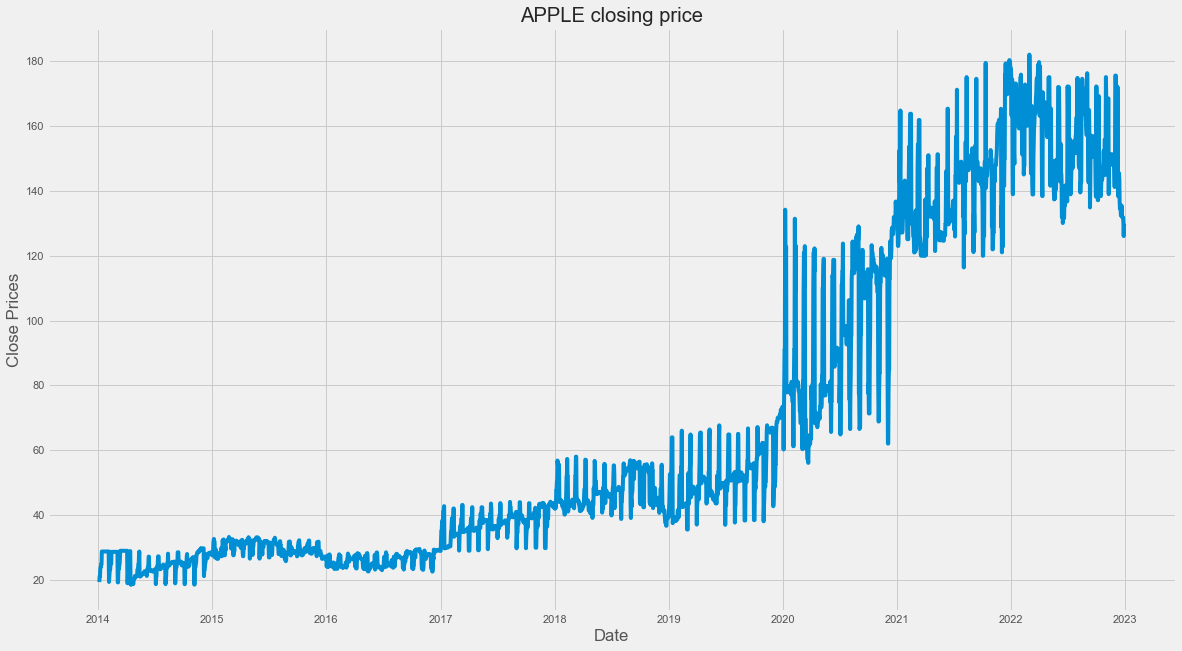

In [24]:
#plot close price
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['close'])
plt.title('APPLE closing price')
plt.show()

# Time series features

In [25]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='close')
features_and_target = pd.concat([X, y], axis=1)

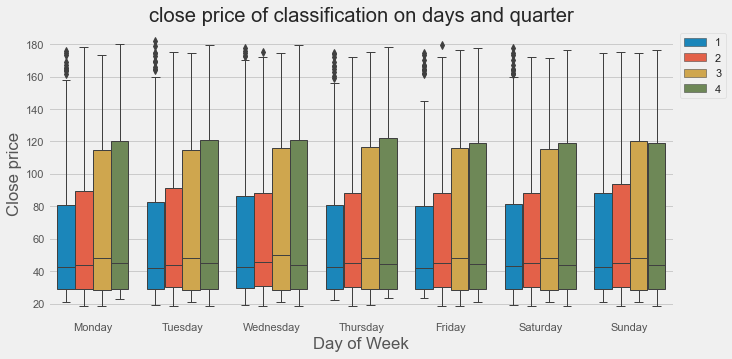

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='close',
            hue='quarter',
            ax=ax,
            linewidth=1)
ax.set_title('close price of classification on days and quarter')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Close price')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Train / Test Split


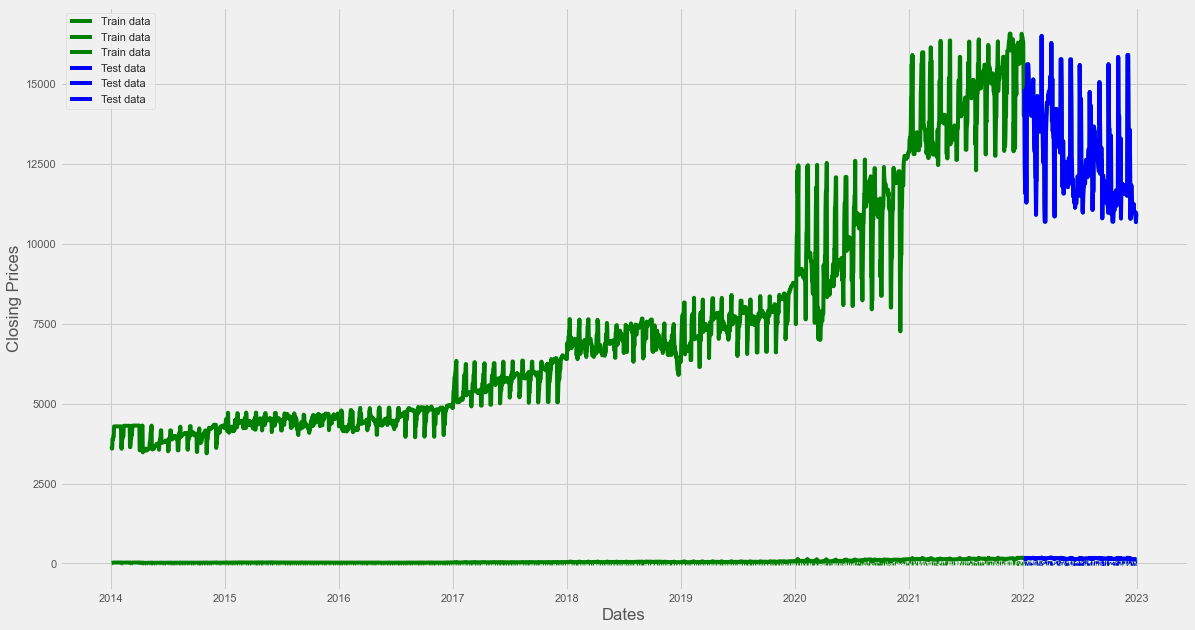

In [27]:
train = df.loc[df.index < '01-04-2022']
test = df.loc[df.index >= '01-04-2022']
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df, 'green', label='Train data')
plt.plot(test, 'blue', label='Test data')
plt.legend()

# Simple Prophet Model


Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
Datetime column named: ds
target : y


In [28]:
# Format data for prophet model using ds and y
train_prophet =train.reset_index() \
    .rename(columns={'index':'ds',
                     'close':'y'})


In [29]:
train_prophet.head()

,ds,y,NASDAQ,Change
0,2014-01-04,19.344643,3658.399902,NaN
1,2014-01-05,21.124287,3594.360107,0.049645
2,2014-01-06,21.124287,3594.360107,NaN
3,2014-01-07,23.379999,3894.330078,0.147499
4,2014-01-08,24.032499,3879.669922,0.132499


In [30]:
%%time
model = Prophet()
model.fit(train_prophet)


DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (C:\Users\akash\anaconda\lib\site-packages\prophet\stan_model\cmdstan-2.31.0\stan\lib\stan_math\lib\tbb) to PATH
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\akash\AppData\Local\Temp\tmpnn30bw76\q4gzxa07.json
DEBUG:cmdstanpy:input tempfile: C:\Users\akash\AppData\Local\Temp\tmpnn30bw76\kio6m0mw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\akash\\anaconda\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=38598', 'data', 'file=C:\\Users\\akash\\AppData\\Local\\Temp\\tmpnn30bw76\\q4gzxa07.json', 'init=C:\\Users\\akash\\AppData\\Local\\Temp\\tmpnn30bw76\\kio6m0mw.json', 'output', 'file=C:\\Users\\akash\\AppData\\Local\\Temp\\tmpnn30bw76\\prophet_modelyy1ez7pj\\prophet_model-20230924190000.csv', 'method=optimize', 'algo

CPU times: total: 688 ms
Wall time: 3.89 s


In [31]:
# Predict on test set with model
test_prophet = test.reset_index() \
    .rename(columns={'index':'ds',
                     'close':'y'})

test_fcst = model.predict(test_prophet)

In [32]:
test_fcst.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-04,163.285013,159.447395,180.432593,163.285013,163.285013,6.585597,6.585597,6.585597,0.040812,0.040812,0.040812,6.544786,6.544786,6.544786,0.0,0.0,0.0,169.870611
1,2022-01-05,163.408665,159.416248,180.487955,163.408665,163.408665,6.342143,6.342143,6.342143,-0.194531,-0.194531,-0.194531,6.536675,6.536675,6.536675,0.0,0.0,0.0,169.750809
2,2022-01-06,163.532317,159.001197,181.383624,163.532317,163.532317,6.428888,6.428888,6.428888,-0.036721,-0.036721,-0.036721,6.465609,6.465609,6.465609,0.0,0.0,0.0,169.961205
3,2022-01-07,163.655969,158.838754,179.455351,163.655969,163.655969,6.135997,6.135997,6.135997,-0.199995,-0.199995,-0.199995,6.335992,6.335992,6.335992,0.0,0.0,0.0,169.791966
4,2022-01-08,163.779621,160.011826,180.541667,163.779621,163.779621,6.105454,6.105454,6.105454,-0.047876,-0.047876,-0.047876,6.153330,6.153330,6.153330,0.0,0.0,0.0,169.885075


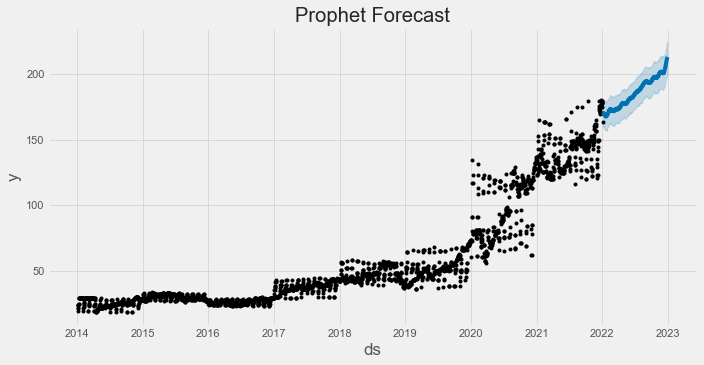

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()


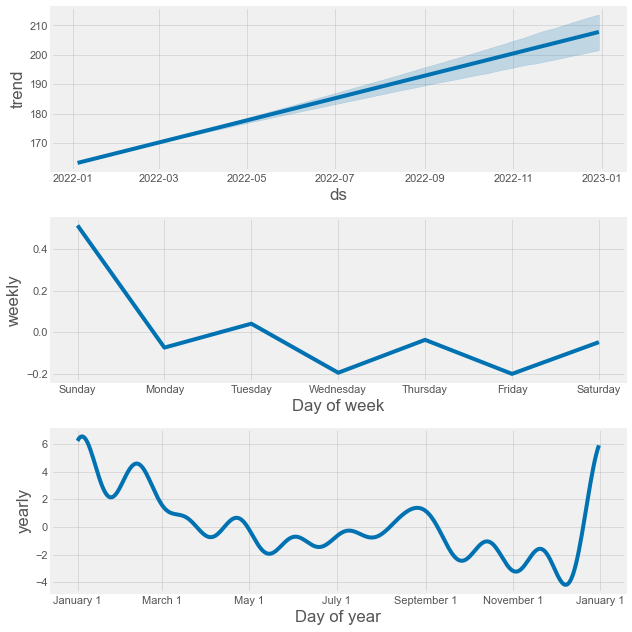

In [34]:
fig = model.plot_components(test_fcst)
plt.show()

# Compare Forecast to Actuals

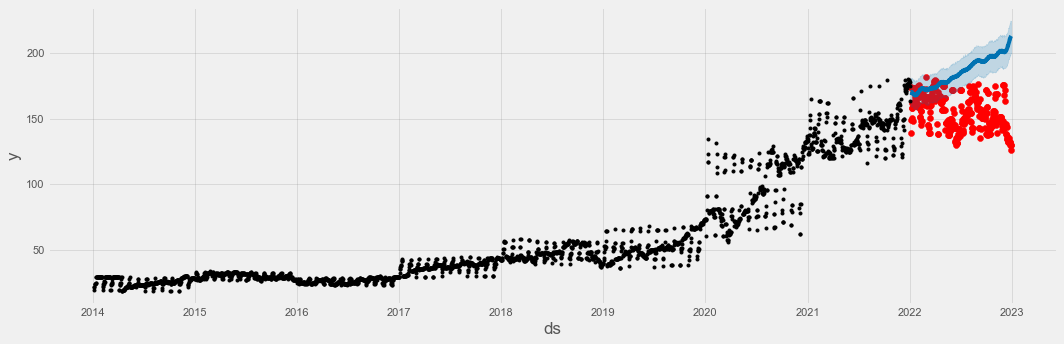

In [35]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test_prophet['y'], color='r')
fig = model.plot(test_fcst, ax=ax)

In [36]:
# plots

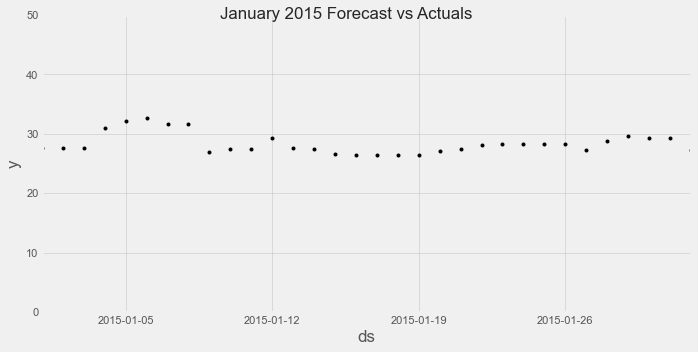

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test_prophet.index, test_prophet['y'], color='r')
fig = model.plot(test_fcst, ax=ax)

# Convert the date strings to datetime objects
lower_limit = pd.to_datetime('2015-01-01')
upper_limit = pd.to_datetime('2015-02-01')

ax.set_xlim(lower_limit, upper_limit)
ax.set_ylim(0, 50)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

plt.show()



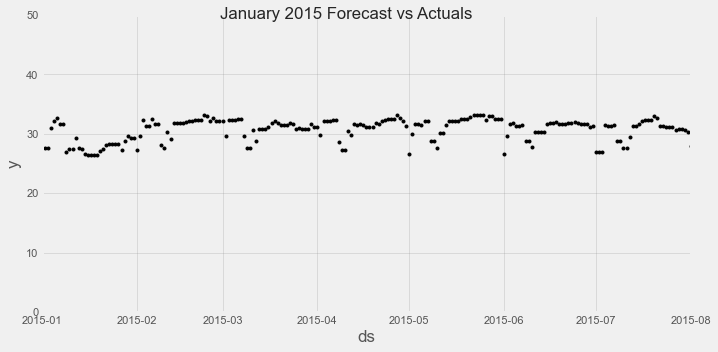

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test_prophet.index, test_prophet['y'], color='r')
fig = model.plot(test_fcst, ax=ax)

# Convert the date strings to datetime objects
lower_limit = pd.to_datetime('2015-01-01')
upper_limit = pd.to_datetime('2015-08-01')

ax.set_xlim(lower_limit, upper_limit)
ax.set_ylim(0, 50)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

plt.show()

# Evaluate the model with Error Metrics


In [53]:
# report performance
mse = mean_squared_error(test_fcst['yhat'], test_prophet['y'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_fcst['yhat'], test_prophet['y'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_fcst['yhat'], test_prophet['y']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_prophet['y'] - test_fcst['yhat'])/np.abs(test_fcst['yhat']))
print('MAPE: '+str(mape))

MSE: 1355.608040389914
MAE: 31.039402474717757
RMSE: 36.81858281343694
MAPE: 0.16258658043313973
